In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

In [2]:
DATA_DIR     = "./dataset"
IMG_SIZE     = (224, 224)
BATCH_SIZE   = 16
INITIAL_EPOCHS = 5
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [4]:
train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
with open("class_names.txt", "w") as f:
    for class_name in train_gen.class_indices.keys():
        f.write(f"{class_name}\n")

Found 84 images belonging to 4 classes.


In [5]:
print("Training generator found:")
print(f"Number of images: {train_gen.n}")
print(f"Number of classes: {train_gen.num_classes}")
print(f"Class indices: {train_gen.class_indices}")

Training generator found:
Number of images: 84
Number of classes: 4
Class indices: {'dipto': 0, 'jayed': 1, 'nafiul': 2, 'talha': 3}


In [6]:
val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_gen.num_classes

Found 20 images belonging to 4 classes.


In [7]:
print("\nValidation generator found:")
print(f"Number of images: {val_gen.n}")
print(f"Number of classes: {val_gen.num_classes}")
print(f"Class indices: {val_gen.class_indices}")



Validation generator found:
Number of images: 20
Number of classes: 4
Class indices: {'dipto': 0, 'jayed': 1, 'nafiul': 2, 'talha': 3}


In [8]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # Freeze VGG layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [9]:
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)

#model.save("face_recognition_model_tf.keras")
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1
)

In [11]:
history_initial = model.fit(
    train_gen,
    epochs=INITIAL_EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.2762 - loss: 1.6080 - val_accuracy: 0.2500 - val_loss: 1.2512 - learning_rate: 0.0010
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4673 - loss: 1.2412 - val_accuracy: 1.0000 - val_loss: 1.0119 - learning_rate: 0.0010
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5323 - loss: 1.0900 - val_accuracy: 1.0000 - val_loss: 0.8558 - learning_rate: 0.0010
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6561 - loss: 0.9843 - val_accuracy: 1.0000 - val_loss: 0.7143 - learning_rate: 0.0010
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8067 - loss: 0.7471 - val_accuracy: 1.0000 - val_loss: 0.6050 - learning_rate: 0.0010


In [12]:
base_model.trainable = True
for layer in base_model.layers:
    if layer.name.startswith('block5_'):
        layer.trainable = True
    else:
        layer.trainable = False


In [13]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
history_fine = model.fit(
    train_gen,
    initial_epoch=history_initial.epoch[-1] + 1,
    epochs=TOTAL_EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)


Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.9590 - loss: 0.6010 - val_accuracy: 1.0000 - val_loss: 0.4209 - learning_rate: 1.0000e-05
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9436 - loss: 0.4325 - val_accuracy: 1.0000 - val_loss: 0.2939 - learning_rate: 1.0000e-05
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9966 - loss: 0.3481 - val_accuracy: 1.0000 - val_loss: 0.2277 - learning_rate: 1.0000e-05
Epoch 9/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9799 - loss: 0.2029 - val_accuracy: 1.0000 - val_loss: 0.1499 - learning_rate: 1.0000e-05
Epoch 10/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 1.0000 - loss: 0.1522 - val_accuracy: 1.0000 - val_loss: 0.1000 - learning_rate: 1.0000e-05
Epoch 11/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9800 - loss: 0.1326 - val_accuracy: 1.0000 - val_loss: 0.0726 - learning_rate: 1.0000e-05
Epoch 12/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 1.0000 - loss: 0.0880 - v

In [15]:
acc = history_initial.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_initial.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history_initial.history['loss'] + history_fine.history['loss']
val_loss = history_initial.history['val_loss'] + history_fine.history['val_loss']
epochs = range(1, len(acc) + 1)

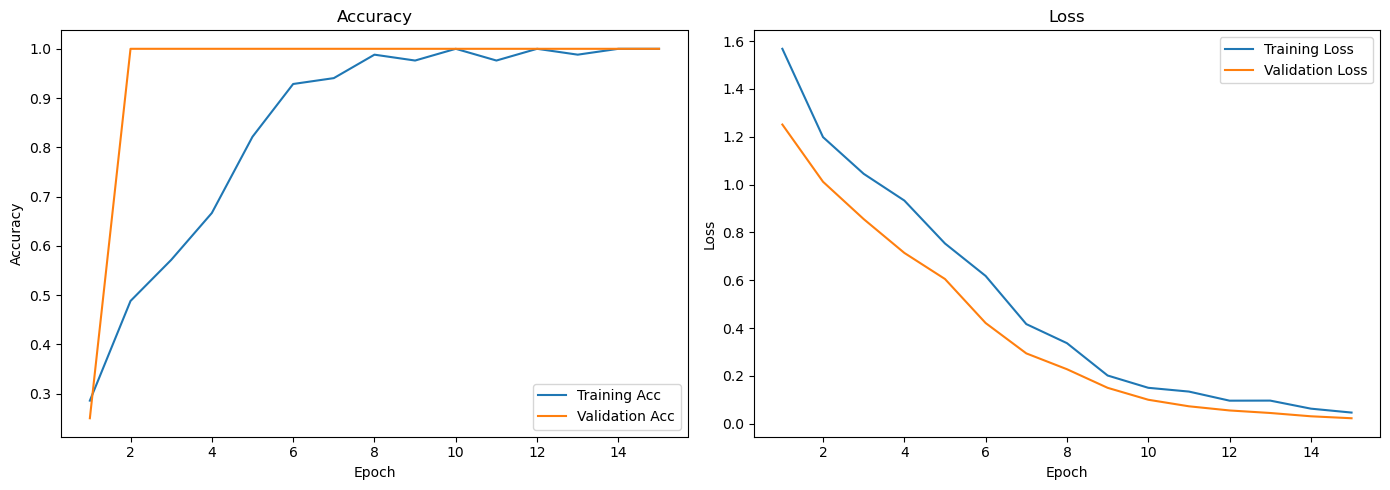

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 514ms/step - accuracy: 1.0000 - loss: 0.0219

Test accuracy: 1.0000


In [16]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc,    label='Training Acc')
plt.plot(epochs, val_acc,label='Validation Acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss,    label='Training Loss')
plt.plot(epochs, val_loss,label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 9. Final evaluation
test_loss, test_acc = model.evaluate(val_gen)
print(f"\nTest accuracy: {test_acc:.4f}")


In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# h = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)


In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
# plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.grid(True)
# plt.legend(loc='lower right')

# plt.subplot(1,2,2)
# plt.plot(h.history['loss'], 'o-', label='train loss')
# plt.plot(h.history['val_loss'], 'o-', label='validation loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.legend(loc='upper right')
